# Binary Classification Modeling

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 200)
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import string
import nltk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from bs4 import BeautifulSoup

sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')

In [2]:
df_binary = pd.read_csv('binary_tweets.csv')
pd.set_option('max_columns', None)
df_binary.groupby('sentiment').describe()

hashtag_count                                                \
                  count      mean       std  min  25%  50%  75%   max   
sentiment                                                               
0                5341.0  1.758285  1.116353  0.0  1.0  1.0  2.0  12.0   
1                2989.0  1.686183  0.969004  0.0  1.0  1.0  2.0  10.0   

          mention_count                                               \
                  count      mean       std  min  25%  50%  75%  max   
sentiment                                                              
0                5341.0  0.752106  0.905020  0.0  0.0  1.0  1.0  8.0   
1                2989.0  0.740381  0.853871  0.0  0.0  1.0  1.0  7.0   

          weblink_count                                               \
                  count      mean       std  min  25%  50%  75%  max   
sentiment                                                              
0                5341.0  0.457218  0.529199  0.0  0.0  0.0  1.0  3.0   
1                2989.0  0.407494  0.503559  0.0  0.0  0.0  1.0  2.0   

          tweet_length                                                    \
                 count       mean       std  min   25%   50%   75%   max   
sentiment                                                                  
0               5341.0  17.340573  4.926567  4.0  14.0  17.0  21.0  32.0   
1               2989.0  17.892606  4.879626  4.0  14.0  18.0  22.0  33.0   

          punct_count                                                
                count      mean       std  min  25%  50%  75%   max  
sentiment                                                            
0              5341.0  3.264183  2.425220  0.0  1.0  3.0  5.0  22.0  
1              2989.0  3.435597  2.326356  0.0  2.0  3.0  5.0  19.0

In [3]:
pd.set_option('max_columns', 10)
df_binary.head(20)

,tweet,brand_product,sentiment,tweet_tokens,hashtag_count,mention_count,weblink_count,tweet_length,punct_count
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,0,"['wesley83', '3g', 'iphone', '3', 'hr', 'tweeting', 'riseaustin', 'dead', 'need', 'upgrade', 'plugin', 'station', 'sxsw']",2,1,0,23,7
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,1,"['jessedee', 'know', 'fludapp', 'awesome', 'ipadiphone', 'app', 'youll', 'likely', 'appreciate', 'design', 'also', 'theyre', 'giving', 'free', 't', 'sxsw']",1,2,0,21,6
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,1,"['swonderlin', 'wait', 'ipad', '2', 'also', 'sale', 'sxsw']",2,1,0,15,2
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,0,"['sxsw', 'hope', 'year', 'festival', 'isnt', 'crashy', 'year', 'iphone', 'app', 'sxsw']",1,1,0,15,4
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)",Google,1,"['sxtxstate', 'great', 'stuff', 'fri', 'sxsw', 'marissa', 'mayer', 'google', 'tim', 'oreilly', 'tech', 'booksconferences', 'matt', 'mullenweg', 'wordpress']",1,1,0,16,11
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,iPad,0,"['teachntech00', 'new', 'ipad', 'apps', 'speechtherapy', 'communication', 'showcased', 'sxsw', 'conference', 'httphtly49n4m', 'iear', 'edchat', 'asd']",5,1,1,18,0
6,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,1,"['sxsw', 'starting', 'ctia', 'around', 'corner', 'googleio', 'hop', 'skip', 'jump', 'good', 'time', 'android', 'fan']",4,0,0,28,2
7,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,iPad or iPhone App,1,"['beautifully', 'smart', 'simple', 'idea', 'rt', 'madebymany', 'thenextweb', 'wrote', 'hollergram', 'ipad', 'app', 'sxsw', 'httpbitlyieavob']",2,2,1,17,1
8,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,1,"['counting', 'day', 'sxsw', 'plus', 'strong', 'canadian', 'dollar', 'mean', 'stock', 'apple', 'gear']",1,0,0,16,0
9,Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1. #fail,Android,1,"['excited', 'meet', 'samsungmobileus', 'sxsw', 'show', 'sprint', 'galaxy', 'still', 'running', 'android', '21', 'fail']",2,1,0,21,2


In [4]:
df_binary['weblink_count'].value_counts()

0    4769
1    3466
2      91
3       4
Name: weblink_count, dtype: int64

In [5]:
df_binary['punct_count'].value_counts()

2     1607
3     1454
1     1324
4     1111
5      805
0      624
6      609
7      345
8      172
9      128
10      71
11      33
12      18
14       8
13       7
15       5
16       3
22       2
18       1
20       1
21       1
19       1
Name: punct_count, dtype: int64

In [6]:
###create test and training sets with binary categories
###remove some of the added features: punctuation, weblink count
tfidf_vec_bin = TfidfVectorizer()
X_tfidf_bin = tfidf_vec_bin.fit_transform(df_binary['tweet_tokens'])
X_tfidf_df_bin = pd.DataFrame(X_tfidf_bin.toarray())
X_tfidf_df_bin.columns = tfidf_vec_bin.get_feature_names()

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [8]:
#Log transform tweet length and then standard scale remaining added features
added_feats = pd.concat([df_binary['hashtag_count'], df_binary['mention_count'], 
                         df_binary['tweet_length']], axis=1)
added_feats['tweet_length'] = added_feats['tweet_length'].map(lambda x: np.log(x))


In [9]:
X_bin_af = pd.concat([added_feats, X_tfidf_df_bin], axis=1)

In [11]:
y_binary = df_binary['sentiment']

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_tfidf_df_bin, y_binary, test_size=0.3, 
                                                                    stratify=y_binary, random_state=123)

In [12]:
X_train_bin_af, X_test_bin_af, y_train_bin_af, y_test_bin_af = train_test_split(X_bin_af, y_binary, 
                                                                                test_size=0.3, 
                                                                                stratify=y_binary, 
                                                                                random_state=123)

In [13]:
scaler = StandardScaler()
train_af_transformed = pd.DataFrame(scaler.fit_transform(X_train_bin_af[['hashtag_count', 
                                                                   'mention_count', 
                                                                   'tweet_length']]))
train_af_transformed.columns = ['hashtags_scaled', 'mentions_scaled', 'tweet_len_log_scaled']

test_af_transformed = pd.DataFrame(scaler.transform(X_test_bin_af[['hashtag_count', 
                                                                   'mention_count', 
                                                                   'tweet_length']]))

test_af_transformed.columns = ['hashtags_scaled', 'mentions_scaled', 'tweet_len_log_scaled']

In [14]:
X_train_af_drop = X_train_bin_af.drop(columns = ['hashtag_count', 'mention_count', 'tweet_length'])
d = X_train_af_drop.reset_index()
e = train_af_transformed
f = pd.concat([d, e], axis=1)
f.set_index(d['level_0'].values, inplace=True)
X_train_bin_af_scaled = f
X_train_bin_af_scaled.drop(columns=['level_0'], inplace=True)

In [15]:
X_test_af_drop = X_test_bin_af.drop(columns = ['hashtag_count', 'mention_count', 'tweet_length'])
a = X_test_af_drop.reset_index()
b = test_af_transformed
c = pd.concat([b, a], axis=1)
c.set_index(a['level_0'].values, inplace=True)
X_test_bin_af_scaled = c
X_test_bin_af_scaled.drop(columns=['level_0'], inplace=True)

## Modeling

In [20]:
mnb = MultinomialNB()
mnb.fit(X_train_bin, y_train_bin)

MultinomialNB()

In [22]:
mnb_cv_mean = np.mean(cross_val_score(mnb, X_train_bin, y_train_bin, cv=5, scoring='accuracy', n_jobs=-1))

In [23]:
print(f"Training Accuracy: {mnb.score(X_train_bin, y_train_bin)}")
print(f"Mean Cross Validation Training Accuracy: {mnb_cv_mean}")
print(f"Testing Accuracy: {mnb.score(X_test_bin, y_test_bin)}")

Training Accuracy: 0.7849425484479506
Mean Cross Validation Training Accuracy: 0.6858160594155163
Testing Accuracy: 0.687875150060024


In [24]:
mnb_2 = MultinomialNB(alpha=2, fit_prior=False)
mnb_2.fit(X_train_bin, y_train_bin)

MultinomialNB(alpha=2, fit_prior=False)

In [25]:
mnb2_cv_mean = np.mean(cross_val_score(mnb_2, X_train_bin, y_train_bin, cv=5, scoring='accuracy', n_jobs=-1))

In [26]:
print(f"Training Accuracy: {mnb_2.score(X_train_bin, y_train_bin)}")
print(f"Mean Cross Validation Training Accuracy: {mnb2_cv_mean}")
print(f"Testing Accuracy: {mnb_2.score(X_test_bin, y_test_bin)}")

Training Accuracy: 0.8188989881666953
Mean Cross Validation Training Accuracy: 0.6854731532230683
Testing Accuracy: 0.6994797919167667


In [60]:
print(classification_report(y_test_bin, mnb_2.predict(X_test_bin)))

              precision    recall  f1-score   support

           0       0.72      0.86      0.79      1602
           1       0.62      0.42      0.50       897

    accuracy                           0.70      2499
   macro avg       0.67      0.64      0.64      2499
weighted avg       0.69      0.70      0.68      2499



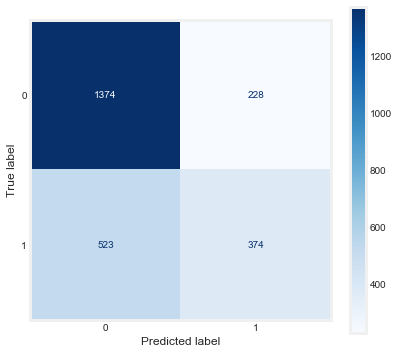

In [61]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.grid(False)
plot_confusion_matrix(mnb_2, X_test_bin, y_test_bin, cmap='Blues', ax=ax)

In [28]:
mnb_af = MultinomialNB()
mnb_af.fit(X_train_bin_af, y_train_bin_af)

MultinomialNB()

In [29]:
mnb_af_cv_mean = np.mean(cross_val_score(mnb_af, X_train_bin_af, 
                                         y_train_bin_af, cv=5, scoring='accuracy', n_jobs=-1))

In [31]:
print(f"Training Accuracy: {mnb_af.score(X_train_bin_af, y_train_bin_af)}")
print(f"Mean Cross Validation Training Accuracy: {mnb2_cv_mean}")
print(f"Testing Accuracy: {mnb_af.score(X_test_bin_af, y_test_bin_af)}")

Training Accuracy: 0.7208026067569885
Mean Cross Validation Training Accuracy: 0.6854731532230683
Testing Accuracy: 0.6718687474989996


In [32]:
rfc = RandomForestClassifier()
rfc.fit(X_train_bin, y_train_bin)

RandomForestClassifier()

In [34]:
rfc_cv_mean = np.mean(cross_val_score(rfc, X_train_bin, y_train_bin, cv=5, scoring='accuracy', n_jobs=-1))

In [35]:
print(f"Training Accuracy: {rfc.score(X_train_bin, y_train_bin)}")
print(f"Mean Cross Validation Training Accuracy: {rfc_cv_mean}")
print(f"Testing Accuracy: {rfc.score(X_test_bin, y_test_bin)}")

Training Accuracy: 0.9945120905505059
Mean Cross Validation Training Accuracy: 0.7168566393429371
Testing Accuracy: 0.7054821928771509


In [62]:
print(classification_report(y_test_bin, rfc.predict(X_test_bin)))

              precision    recall  f1-score   support

           0       0.72      0.89      0.79      1602
           1       0.65      0.38      0.48       897

    accuracy                           0.71      2499
   macro avg       0.69      0.63      0.64      2499
weighted avg       0.70      0.71      0.68      2499



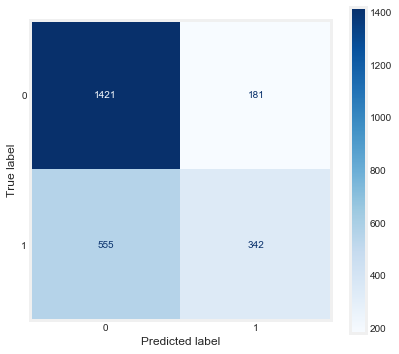

In [64]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.grid(False)
plot_confusion_matrix(rfc, X_test_bin, y_test_bin, cmap='Blues', ax=ax)

In [48]:
rfc_af = RandomForestClassifier()
rfc_af.fit(X_train_bin_af_scaled, y_train_bin_af)

RandomForestClassifier()

In [50]:
rfc_af_cv_mean = np.mean(cross_val_score(rfc_af, X_train_bin_af_scaled, y_train_bin_af, 
                                        cv=5, scoring='accuracy', n_jobs=-1))

In [51]:
print(f"Training Accuracy: {rfc_af.score(X_train_bin_af_scaled, y_train_bin_af)}")
print(f"Mean Cross Validation Training Accuracy: {rfc_af_cv_mean}")
print(f"Testing Accuracy: {rfc_af.score(X_test_bin_af_scaled, y_test_bin_af)}")

Training Accuracy: 0.9957125707425828
Mean Cross Validation Training Accuracy: 0.7122267443313182
Testing Accuracy: 0.6350540216086434


In [53]:
linear_svc = SVC(kernel='linear')
linear_svc.fit(X_train_bin, y_train_bin)

SVC(kernel='linear')

In [54]:
linear_svc_cv_mean = np.mean(cross_val_score(linear_svc, X_train_bin, y_train_bin,
                                            cv=5, scoring='accuracy', n_jobs=-1))

In [56]:
print(f"Training Accuracy: {linear_svc.score(X_train_bin, y_train_bin)}")
print(f"Mean Cross Validation Training Accuracy: {linear_svc_cv_mean}")
print(f"Testing Accuracy: {linear_svc.score(X_test_bin, y_test_bin)}")

Training Accuracy: 0.8605728005487909
Mean Cross Validation Training Accuracy: 0.7197725913154928
Testing Accuracy: 0.7278911564625851


In [65]:
print(classification_report(y_test_bin, linear_svc.predict(X_test_bin)))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81      1602
           1       0.70      0.42      0.53       897

    accuracy                           0.73      2499
   macro avg       0.72      0.66      0.67      2499
weighted avg       0.72      0.73      0.71      2499



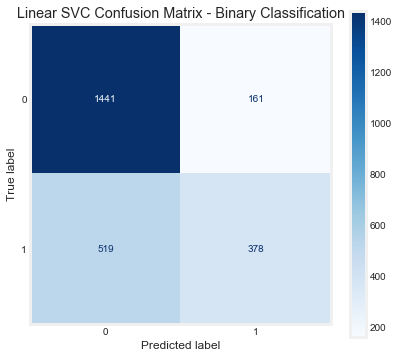

In [81]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.grid(False)
plot_confusion_matrix(linear_svc, X_test_bin, y_test_bin, cmap='Blues', ax=ax)
plt.title('Linear SVC Confusion Matrix - Binary Classification')
plt.savefig('linear_svc_confusion_matrix.png')

In [82]:
from sklearn.metrics import roc_curve, auc

y_score = linear_svc.decision_function(X_test_bin)
fpr, tpr, thresholds = roc_curve(y_test_bin, y_score)

print(f"AUC: {auc(fpr, tpr)}")

AUC: 0.7583650314475913


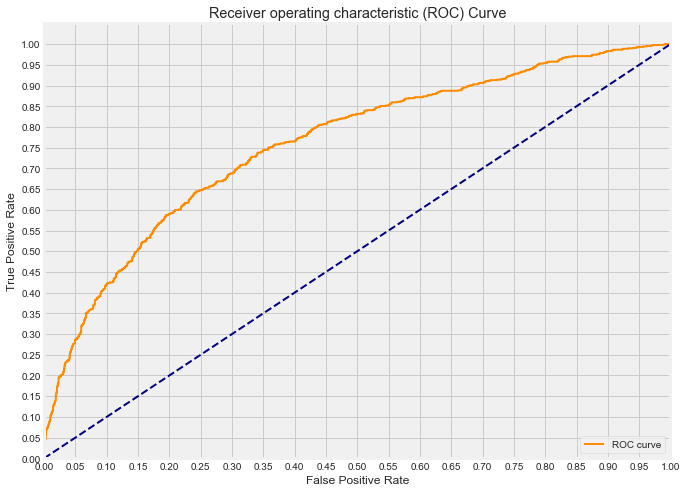

In [83]:
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')

In [67]:
gs_linear = SVC()

In [73]:
linear_param = {'C':[0.1, 1, 10],
                     'kernel':['linear'], 
                    'class_weight':[None, 'balanced'], 
                    }

gs_linear_svc = GridSearchCV(gs_linear, param_grid=linear_param, cv=5, n_jobs=-1)
gs_linear_svc.fit(X_train_bin, y_train_bin)

gs_linear_svc.best_params_

{'C': 1, 'class_weight': None, 'kernel': 'linear'}

In [57]:
rbf_svc = SVC(kernel='rbf')
rbf_svc.fit(X_train_bin, y_train_bin)

SVC()

In [58]:
rbf_svc_cv_mean = np.mean(cross_val_score(rbf_svc, X_train_bin, y_train_bin,
                                         cv=5, scoring='accuracy', n_jobs=-1))

In [59]:
print(f"Training Accuracy: {rbf_svc.score(X_train_bin, y_train_bin)}")
print(f"Cross Validation Mean Accuracy: {rbf_svc_cv_mean}")
print(f"Testing Accuracy: {rbf_svc.score(X_test_bin, y_test_bin)}")


Training Accuracy: 0.9257417252615332
Cross Validation Mean Accuracy: 0.717199839496973
Testing Accuracy: 0.7214885954381752


In [68]:
from imblearn.over_sampling import RandomOverSampler

In [69]:
y_train_bin.value_counts()

0    3739
1    2092
Name: sentiment, dtype: int64

In [70]:
oversample = RandomOverSampler(sampling_strategy='minority', random_state=123)
X_over_train, y_over_train = oversample.fit_resample(X_train_bin, y_train_bin)

In [71]:
y_over_train.value_counts()

1    3739
0    3739
Name: sentiment, dtype: int64

In [76]:
svc_over = SVC(kernel='linear', C=1)
svc_over.fit(X_over_train, y_over_train)

SVC(C=1, kernel='linear')

In [77]:
svc_over_cv_mean = np.mean(cross_val_score(svc_over, X_over_train, y_over_train,
                                          cv=5, scoring='accuracy', n_jobs=-1))

In [78]:
print(f"Training Accuracy: {svc_over.score(X_over_train, y_over_train)}")
print(f"Cross Validation Mean: {svc_over_cv_mean}")
print(f"Testing Accuracy: {svc_over.score(X_test_bin, y_test_bin)}")

Training Accuracy: 0.8892752072746724
Cross Validation Mean: 0.7674633806091606
Testing Accuracy: 0.7058823529411765
